In [1]:
import pandas as pd
import xarray as xr
import os
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

import allel

In [ ]:
read_vcf('../gea_grene-net/key_files/vcf')

In [5]:
vcf = allel.read_vcf('../gea_grene-net/gwas/1001g/1001g_grenet_climate.recode.vcf', fields = ['samples'])

In [11]:
len(vcf['samples'])

1137

In [9]:
7427 in vcf['samples']

False

In [17]:
ecotypes = pd.read_csv('1001_g.csv', header=None)

In [15]:
vcf['samples']

array(['10001', '10002', '10004', ..., '9940', '9977', '9992'],
      dtype=object)

In [24]:
len(set(ecotypes[0].astype(str).values).intersection(set(vcf['samples'])))

1131

In [14]:
len(ecotypes)

1134

In [12]:
ecotypes = pd.read_csv('1001g_regmap_grenet_ecotype_info_corrected_2024may16.csv')

In [14]:
ecotypes[ecotypes['country'] == 'DEN']

,ecotype_id,source,GrENE-net,country,Latitude_corrected,Longitude_corrected
63,7164,1TG,True,DEN,55.675,12.5686


In [8]:
ecotypes = pd.read_csv('list_ecotypes_arapheno.csv')

In [ ]:
ecotypes[7427]

In [11]:
ecotypes[ecotypes['pk'] == 7427]

,pk,name,country,latitude,longitude,collector,collection_date,cs_number,species,genotypes,count_phenotypes
4930,7427,Ko-2,DEN,NaN,NaN,Albert Kranz,NaN,CS76531,Arabidopsis thaliana,NaN,17


In [2]:
def summarize_temp(file_name):
    ds = xr.open_dataset(file_name ,engine='cfgrib', backend_kwargs={'indexpath': ''})
    df = ds.to_dataframe().reset_index()
    ## since there are somee xtraline before adn after
    df = df.dropna()
    ## convert temp to celcius
    df['t2m'] = df['t2m'] - 273.15
    ## convert temp to celcius
    ecotype = file_name.split('_')[4]
    df['ecotype'] = ecotype
    df['month'] = df['valid_time'].dt.month
    df['year'] = df['valid_time'].dt.year
    df_max = df.groupby(['longitude', 'latitude','ecotype','year', 'month'])['t2m'].max().reset_index().rename(columns={'t2m':'t2m_max'})
    df_min = df.groupby(['longitude', 'latitude','ecotype','year', 'month'])['t2m'].min().reset_index().rename(columns={'t2m':'t2m_min'})
    df = pd.merge(df_max,df_min)
    return df

In [3]:
def summarize_prec_era5land(file_name):
    ds = xr.open_dataset(file_name ,engine='cfgrib', backend_kwargs={'indexpath': ''})
    df = ds.to_dataframe().reset_index()
    ## since there are somee xtraline before adn after
    df = df.dropna()
    ## convert total precipitation to mm
    df['tp_mm'] = df['tp'] * 1000
    ecotype = file_name.split('_')[4]
    df['ecotype'] = ecotype
    df['day'] = df['valid_time'].dt.day
    df['month'] = df['valid_time'].dt.month
    df['year'] = df['valid_time'].dt.year
    ################## this part is true if we use netcdf but if we use grib it is righly hourly accumulated ################
    ################## dont fuckign ask me why ######################################
    ## era5 land has data accumulated based on daily precipitation, so it accumulates over a day and then resets
    ## but it resets after 00:00:00, so the max of the previous day is shown at 00:00:00 of the next day 
    ## i will shift the column and take the max of each day (aka the accumulated in one day)
    #df['tp_mm'] = df['tp_mm'].shift(-1)
    #df = df.groupby(['longitude', 'latitude','ecotype','year', 'month', 'day'])['tp_mm'].max().reset_index()
    ## then calcualte hte accumulated over the month 
    #df = df.groupby(['longitude', 'latitude','ecotype','year', 'month'])['tp_mm'].sum().reset_index()
    ################## this part is true if we use netcdf but if we use grib it is righly hourly accumulated ################
    ################## dont fuckign ask me why ######################################
    ## for grid: 
    df = df.groupby(['longitude', 'latitude','ecotype','year', 'month'])['tp_mm'].sum().reset_index()

    return df

In [4]:
def summarize_prec_era5(file_name):
    print(file_name)
    ds = xr.open_dataset(file_name)
    df = ds.to_dataframe()
    df = df.reset_index()
    
    df['tp_mm'] = df['tp'] * 1000
    site = file_name.split('_')[2]
    df['site'] = site
    df['day'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year
    
    df = df.groupby(['longitude', 'latitude','site','year', 'month'])['tp_mm'].sum().reset_index()
    return df

In [5]:
#os.listdir('/carnegie/nobackup/scratch/tbellagio/climate_grenet')

In [4]:
## get all files
path = '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/'
all_files_avail = [path + i for i in os.listdir(path) if '.nc' in i and '.idx' not in i]

In [5]:
## get them for teh right years
#all_files = [i for i in all_files if '2018' in i or '2019' in i or '2020' in i] #or '2021' in i]
## get the precipitation ones
all_files_prec = [i for i in all_files_avail if 'prec' in i]
## get the temperature ones 
all_files_temp = [i for i in all_files_avail if 'temp' in i]

In [9]:
all_files_temp

['/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_9969_1997_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_2191_1995_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_470_2004_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_6119_2002_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_15593_2001_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_9686_1996_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_9540_1999_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_7202_2004_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagio/climate_grenet/new_files/era5_ecotype_9713_1997_2m_temperature.nc',
 '/carnegie/nobackup/scratch/tbellagi

In [8]:
!pwd

/carnegie/nobackup/scratch/tbellagio/climate_grenet


In [9]:
ecotypes = pd.read_csv('1001g_regmap_grenet_ecotype_info_corrected_2024may16.csv')

In [10]:
6939 in ecotypes['ecotype_id'].values

6939 in ecotypes['ecotype_id']

False

In [11]:
print(ecotypes['ecotype_id'].iloc[230])

6939


In [12]:
ecotypes[ecotypes['ecotype_id']==6939]

,ecotype_id,source,GrENE-net,country,Latitude_corrected,Longitude_corrected
230,6939,regmap,True,LIB,32.34,22.46


In [13]:
ecotypes = ecotypes[ecotypes['source'] != 'regmap']

In [14]:
6939 in ecotypes['ecotype_id']

False

In [15]:
len(ecotypes) * 2 * 10 ##2 prec and temp # 10 years
## and i hsould get 20 extra

22720

In [16]:
len(all_files_avail)

22740

In [17]:
(len(all_files_avail) * 100) / (len(ecotypes) * 2 * 10)

100.08802816901408

In [7]:
all_files_avail = pd.Series(all_files_avail)
ecotype = all_files_avail.str.split('/').str[-1].str.split('_').str[2]
all_files_avail = pd.DataFrame(all_files_avail)

all_files_avail['ecotype'] = ecotype

all_files_ecotypeb = all_files_avail.groupby('ecotype')[0].unique().reset_index()
all_files_ecotypeb.columns = ['ecotype', 'files']
all_files_ecotypen = all_files_avail.groupby('ecotype')[0].nunique().reset_index()
all_files_ecotypen.columns = ['ecotype', 'nfiles']

all_files_pecoytype = all_files_ecotypen.merge(all_files_ecotypeb)

In [8]:
all_files_pecoytype

,ecotype,nfiles,files
0,100001,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
1,100002,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
2,10001,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
3,10002,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
4,10004,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
...,...,...,...
1132,9995,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
1133,9996,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
1134,9997,20,[/carnegie/nobackup/scratch/tbellagio/climate_...
1135,9998,20,[/carnegie/nobackup/scratch/tbellagio/climate_...


In [19]:
len(set(all_files_pecoytype['ecotype'].unique()))

1137

In [20]:
done = pd.Series(os.listdir('climate_agg_files')).str.split('_').str[-1].str.replace('.csv', '')

In [21]:
len(done)

1137

In [22]:
ecotypes_left = set(all_files_pecoytype['ecotype'].unique()) - set(done)

In [23]:
len(ecotypes_left)

1

In [24]:
#267

In [25]:
number = int(sys.argv[1])

NameError: name 'sys' is not defined

In [ ]:
ecotypes_left[0]

In [26]:
#for i in os.listdir('climate_agg_files'):
#    data = pd.read_csv('climate_agg_files/' + i)
#    print(data.isna().sum().sum())

In [27]:
for ecotype in ecotypes_left:

    ## make sure it has all the prec and temp files
    if all_files_pecoytype[all_files_pecoytype['ecotype']==ecotype]['nfiles'].values[0] == 20:
        print(type(ecotype))
        print(ecotype)
        print(',')
        
        files_one_e = all_files_pecoytype[all_files_pecoytype['ecotype']==ecotype]['files'].values[0]
        
        files_one_e_prec = [i for i in files_one_e if 'prec' in i]
        ## get the temperature ones 
        files_one_e_temp = [i for i in files_one_e if 'temp' in i]
        
        all_df = {}
        for i in files_one_e_prec:
            df = summarize_prec_era5land(i)
            all_df[i] = df
        prec_df = pd.concat(all_df).reset_index(drop=True)
        
        all_df = {}
        for i in files_one_e_temp:
            df = summarize_temp(i)
            all_df[i] = df
        temp_df = pd.concat(all_df).reset_index(drop=True)
        
        climate_df = prec_df.merge(temp_df, on = ['longitude', 'latitude', 'ecotype', 'year', 'month'])
        
        # Group by site and month, then calculate the average of each climate variable across all years
        climate_df_agg = climate_df.groupby(['ecotype', 'month']).agg({
            't2m_max': 'mean',
            't2m_min': 'mean',
            'tp_mm': 'mean'
        }).reset_index()
        
        climate_df_agg.to_csv(f'climate_agg_files/climate_aggregate_ecotype_{ecotype}.csv',index=None)

<class 'str'>
6939
,


In [2]:
pd.read_csv('climate_agg_files/climate_aggregate_ecotype_1317.csv')

,ecotype,month,t2m_max,t2m_min,tp_mm
0,1317,1,5.070880,-18.537586,40.024513
1,1317,2,7.450787,-16.818989,35.784110
2,1317,3,12.880499,-11.142616,34.385612
3,1317,4,19.646442,-5.878900,44.189540
4,1317,5,23.567413,-1.332367,53.005604
5,1317,6,25.539337,4.268829,76.067890
6,1317,7,27.843048,7.423224,85.460650
7,1317,8,27.214802,5.012189,54.296467
8,1317,9,21.915289,-1.122577,53.884937
9,1317,10,14.783991,-5.423212,54.331642


In [21]:
!pwd

/carnegie/nobackup/scratch/tbellagio/climate_grenet


In [ ]:
## launc jobs to do the reovious script 

In [127]:
shfiles = []
for ecotype in ecotypes_left:
    file = f'shfiles/ecotypes_proc_{ecotype}.sh'
    text = f'''#!/bin/bash
#SBATCH --job-name=ecotypes_proc_{ecotype}
#SBATCH --time=1:00:00  
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=10gb
#SBATCH --cpus-per-task=1
#SBATCH --output=ecotypes_proc_{ecotype}.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

# Source the conda.sh script
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh

# Activate the conda environment
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake

cd /home/tbellagio/scratch/climate_grenet/
python ecotypes_proc.py {ecotype}
    
    
    '''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [128]:
subprocess.run(["sbatch", shfiles[0]], check=True)

Submitted batch job 6805


CompletedProcess(args=['sbatch', 'shfiles/ecotypes_proc_9908.sh'], returncode=0)

In [ ]:
for shfile in shfiles[1:]:
    subprocess.run(["sbatch", shfile], check=True)

In [21]:
pd.read_csv('climate_agg_files/climate_aggregate_ecotype_5993.csv')

,ecotype,month,t2m_max,t2m_min,tp_mm
0,5993,1,6.623362,-15.411052,6.695501
1,5993,2,9.383209,-13.609670,7.051250
2,5993,3,14.653011,-7.239946,8.643352
3,5993,4,20.213340,-3.225298,12.839149
4,5993,5,24.803185,3.044586,19.459743
5,5993,6,27.669071,6.205610,27.889656
6,5993,7,28.948761,8.820221,30.537220
7,5993,8,28.846685,8.519000,20.969260
8,5993,9,23.364435,3.579498,13.879756
9,5993,10,18.937994,-1.921137,10.729529


In [ ]:

files = [i for i in os.listdir('climate_agg_files') if 'ecotype' in i and '.csv' in i]
all_ecotypes = {}
for i in files:
    ecotype = pd.read_csv('climate_agg_files/' + i)
    all_ecotypes[i] = ecotype

all_ecotypes = pd.concat(all_ecotypes).reset_index(drop=True)

all_ecotypes

In [32]:
climate_prec = all_ecotypes.pivot(index='ecotype', columns=['month'], values='tp_mm')
climate_max_temp = all_ecotypes.pivot(index='ecotype', columns=['month'], values='t2m_max')
climate_min_temp = all_ecotypes.pivot(index='ecotype', columns=['month'], values='t2m_min')

In [33]:
climate_prec.to_csv('climate_prec_ecotypes.csv')
climate_max_temp.to_csv('climate_max_temp_ecotypes.csv')
climate_min_temp.to_csv('climate_min_temp_ecotypes.csv')

In [34]:
## run the dismo package from R to get the bioclim variables
subprocess.call("~/miniforge3/envs/r-environment/bin/Rscript --vanilla  /home/tbellagio/scratch/climate_grenet/run_dismo_bioclim_calc_ecotypes.R", 
                shell=True)

Loading required package: raster
Loading required package: sp


0

In [35]:
bio_clim_vars = pd.read_csv('bio_clim_vars_ecotypes.csv')

In [36]:
bio_clim_vars = bio_clim_vars.set_index(climate_min_temp.index)

bio_clim_vars.index = bio_clim_vars.index.astype(float).astype(int)

In [37]:
bio_clim_vars.to_csv('../grene/data/bioclimvars_ecotypes_era5.csv', index=True, header=True)

In [54]:
bio_clim_vars.to_csv('bioclimvars_ecotypes_era5.csv', index=True, header=True)

In [38]:
pwd!

'/carnegie/nobackup/scratch/tbellagio/climate_grenet'

In [39]:
len(bio_clim_vars)

1137

In [74]:
#pd.read_csv('../grene/data/sites_clim.csv')

In [340]:
[i for i in os.listdir('../grene/data/') if 'ecotype' in i]

['ecotypes_frequencies.rda',
 'worldclim_ecotypesdata.rda',
 'ecotypes_data.rda',
 'ecotypes_data.csv',
 'bioclimvars_ecotypes_era5.csv',
 'worldclim_ecotypesdata.csv',
 'ecotypes_frequencies_wide.rda',
 'ecotypes_frequencies_long.rda']

In [40]:
bios_old = pd.read_csv('../grene/data/worldclim_ecotypesdata.csv')

In [41]:
bios_old = pd.read_csv('../grene/data/worldclim_ecotypesdata.csv')[['ecotypeid','bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6',
       'bio7', 'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19']]

In [42]:
bios_old = bios_old.set_index('ecotypeid', drop=True)

In [43]:
bios_old = bios_old.add_suffix('_old')

In [44]:
bio_clim_vars = bio_clim_vars.add_suffix('_new')

In [80]:
#bios_old = bios_old.drop(6939)

In [45]:
6939 in bios_old.index

True

In [46]:
6939 in bio_clim_vars.index

True

In [47]:
inter = set(bio_clim_vars.index).intersection(set(bios_old.index))

In [48]:
inter = list(inter)

In [49]:
bio_clim_vars_red = bio_clim_vars.loc[inter, :]

In [50]:
bios_old_red = bios_old.loc[inter, :]

In [51]:
bio_clim_vars_red

,bio1_new,bio2_new,bio3_new,bio4_new,bio5_new,bio6_new,bio7_new,bio8_new,bio9_new,bio10_new,bio11_new,bio12_new,bio13_new,bio14_new,bio15_new,bio16_new,bio17_new,bio18_new,bio19_new
ecotype,,,,,,,,,,,,,,,,,,,
6150,6.816034,19.274925,45.910171,765.055991,25.934113,-16.049885,41.983998,16.010948,-1.451653,16.010948,-3.132999,790.117624,97.587395,46.677820,23.128317,261.315445,157.678407,261.315445,167.084724
9736,11.608236,22.488369,48.376728,890.473861,34.446710,-12.039215,46.485925,22.298729,2.683804,22.298729,-0.110726,827.501979,109.939865,34.302660,32.437656,292.317005,134.198716,292.317005,134.648750
9737,10.500890,23.194720,51.008666,821.649215,32.182842,-13.289274,45.472116,18.733331,2.064829,20.229612,-0.546294,914.848749,105.465256,55.361450,26.552610,289.962570,167.507507,285.153640,177.175377
9739,10.802189,23.356641,51.037580,825.473629,32.522297,-13.241316,45.763613,19.480491,2.395900,20.601288,-0.256667,876.924987,102.060850,52.358868,25.257791,271.308130,163.471555,268.178486,177.258287
9741,9.509144,22.848928,51.218134,810.861276,30.805622,-13.805389,44.611011,19.046791,0.979339,19.046791,-1.395143,994.112692,125.287150,54.742260,32.981462,341.410326,171.832032,341.410326,173.135696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,13.438280,23.193146,49.918013,827.098419,35.689950,-10.772528,46.462478,4.907628,23.918809,23.918809,3.222280,635.081518,88.612870,28.379470,29.711299,199.512325,106.117984,106.117984,193.732563
9723,10.723780,22.867296,51.452520,792.504379,32.451103,-11.992388,44.443491,2.385840,19.643829,20.562327,0.715068,810.930808,108.459755,45.531754,25.815180,248.442675,151.932279,161.570764,232.889525
7164,8.090432,16.490409,42.907908,728.405388,25.935090,-12.497007,38.432097,17.034609,3.608515,17.034609,-1.034160,719.716376,84.558270,45.335450,18.313419,217.357740,147.926550,217.357740,160.530170


In [52]:
# Concatenate the dataframes side by side
combined_df = pd.concat([bios_old, bio_clim_vars], axis=1)

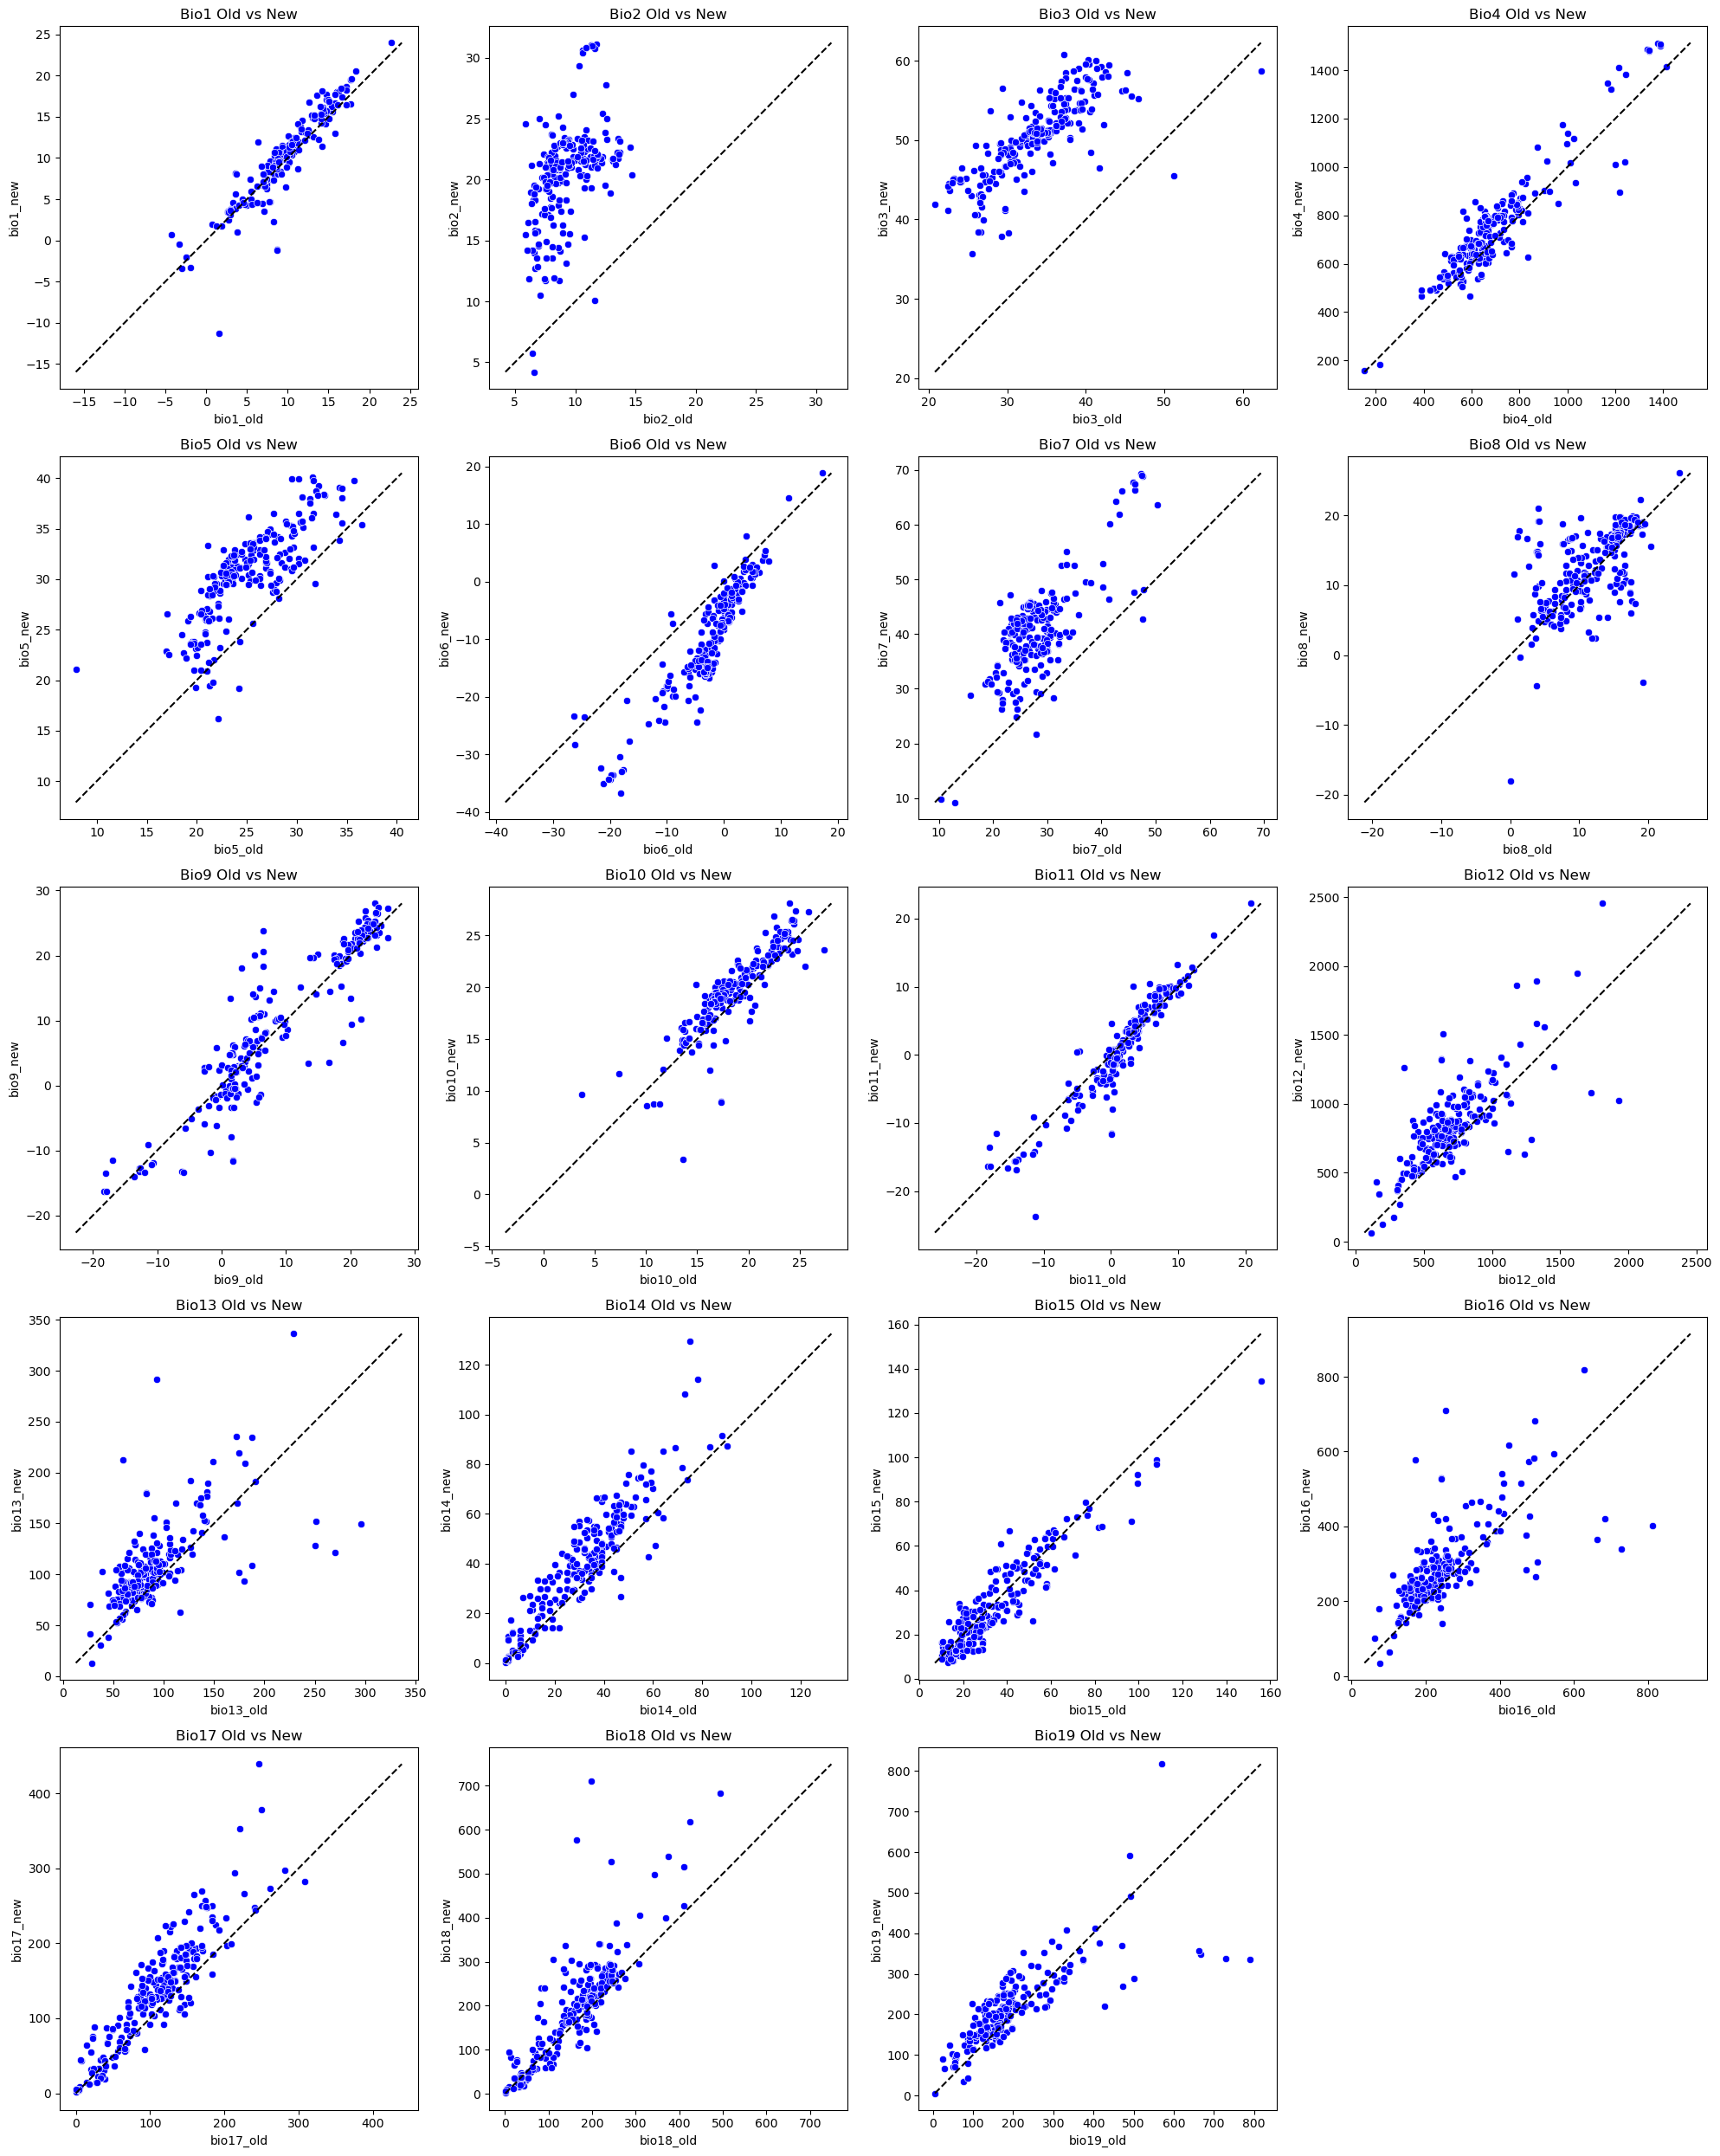

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'combined_df' has columns like 'bio1_old', 'bio1_new', ..., 'bio19_old', 'bio19_new'
# Number of biovars
num_biovars = 19

# Set up the plotting environment, adjusting for 19 subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 25))  # Adjusted to fit 19 plots in a 5x4 grid

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Loop over the number of biovars
for i in range(num_biovars):
    # Construct column names
    old_col = f'bio{i+1}_old'
    new_col = f'bio{i+1}_new'
    
    # Plot each pair
    sns.scatterplot(data=combined_df, x=old_col, y=new_col, ax=axs[i], color='blue')
    axs[i].set_title(f'Bio{i+1} Old vs New')
    
    # Calculate limits for the 1:1 line
    max_limit = np.maximum(combined_df[old_col].max(), combined_df[new_col].max())
    min_limit = np.minimum(combined_df[old_col].min(), combined_df[new_col].min())
    
    # Plot the 1:1 line
    axs[i].plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Black dashed line

# Hide unused subplots if not a perfect grid match
for ax in axs[num_biovars:]:
    ax.set_visible(False)

plt.tight_layout()

plt.savefig('trend_bioclim.png')
plt.show()


In [95]:
combined_df

,bio1_old,bio2_old,bio3_old,bio4_old,bio5_old,bio6_old,bio7_old,bio8_old,bio9_old,bio10_old,...,bio10_new,bio11_new,bio12_new,bio13_new,bio14_new,bio15_new,bio16_new,bio17_new,bio18_new,bio19_new
6915,7.525000,7.233333,31.586609,595.752014,20.400000,-2.500000,22.900000,1.466667,10.200000,14.983334,...,17.137360,-0.287950,1060.964910,104.229140,78.730820,8.283749,284.189925,247.930650,279.023950,284.189925
9606,14.066667,11.750000,39.036545,638.105591,30.600000,0.500000,30.100000,9.866667,22.116667,22.216667,...,22.552265,8.949717,563.797515,92.395620,12.395829,41.855253,212.698814,76.201966,76.201966,133.986240
5768,9.104167,7.258333,37.607944,451.187622,20.200001,0.900000,19.300001,4.783333,5.650000,14.883333,...,15.992812,4.078623,792.760794,77.410740,52.665306,10.957452,212.214321,184.202146,205.117741,201.831106
9992,9.887500,10.158334,28.941122,912.989929,29.299999,-5.800000,35.099998,3.016667,21.016666,21.016666,...,21.192950,-3.762190,914.033090,158.062820,2.558995,72.300340,441.886400,27.451884,35.396402,335.154860
9481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.349396,-2.594650,768.104511,95.013954,46.375694,22.432676,251.057134,154.375906,251.057134,164.504144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,7.075000,6.566667,29.848486,577.406006,19.400000,-2.600000,22.000000,3.816667,9.950000,14.483334,...,13.714960,-5.398521,2453.969850,336.305850,129.374730,29.040061,817.635880,439.129300,496.942620,817.046620
9978,8.716667,10.466667,36.216839,703.062561,24.200001,-4.700000,28.900002,17.333334,1.750000,17.333334,...,8.924599,-11.615901,1321.434159,179.044420,48.927303,44.469238,526.422480,152.761031,526.422480,152.761031
7036,7.800000,8.000000,31.872511,651.585510,21.799999,-3.300000,25.099998,1.033333,7.383334,15.950001,...,17.946747,-0.514974,1037.242670,110.390915,77.082510,10.618783,277.518115,233.446490,265.271245,265.948370
6013,3.508333,7.950000,26.500000,791.215515,19.900000,-10.100000,30.000000,3.783333,2.133333,13.833333,...,14.831352,-5.945234,711.397702,77.621120,36.273304,22.160891,214.701512,135.117814,214.701512,157.331091


In [363]:
combined_df[['bio12_new','bio12_old']]

,bio12_new,bio12_old
7028,1011.655366,815.0
7062,837.420936,655.0
7125,877.699959,755.0
7217,788.590606,694.0
9528,516.255443,462.0
9579,541.769208,423.0
9632,446.215794,331.0
9659,1139.054969,897.0
9716,1088.976164,624.0
9941,1432.207440,1205.0


In [362]:
combined_df['bio12_new'] / combined_df['bio12_old']

7028    1.241295
7062    1.278505
7125    1.162517
7217    1.136298
9528    1.117436
9579    1.280778
9632    1.348084
9659    1.269849
9716    1.745154
9941    1.188554
9944    1.186110
dtype: float64

In [113]:
ecotypes

,ecotype_id,source,GrENE-net,country,Latitude_corrected,Longitude_corrected
0,159,1TG,True,FRA,47.3500,3.93333
1,265,1TG,True,FRA,44.6500,-1.16667
2,763,1TG,True,KGZ,42.3000,74.36670
3,765,1TG,True,KGZ,42.1833,73.40000
4,766,1TG,True,KGZ,42.5833,73.63330
...,...,...,...,...,...,...
1866,9482,regmap,False,SWE,56.0648,13.97070
1867,9490,regmap,False,UK,55.9218,-3.17108
1868,9496,regmap,False,UK,55.9212,-3.17857
1869,9499,regmap,False,UK,55.8858,-3.16015


In [116]:
combined_df[['bio12_old', 'bio12_new']].reset_index().merge(ecotypes, left_on = 'index', right_on = 'ecotype_id' ).to_csv('chat.csv')

In [101]:
[i for i in os.listdir('../grene/data/') if 'weatherstation' in i]

['weatherstation_info.csv',
 'weatherstation_bioclim.csv',
 'weatherstation_data.rda',
 'weatherstation_info.rda',
 'weatherstation_data.csv',
 'weatherstation_bioclim.rda']

In [104]:
ws = pd.read_csv('../grene/data/weatherstation_data.csv')


In [105]:
ws

,site,stationid,weatherdate,temp,dewp,slp,stp,visib,wdsp,mxspd,gust,max,min,prcp,sndp,frshtt
0,1,10738099999,2017-01-01,-5.1,-6.2,NaN,NaN,1.8,0.9,2.6,NaN,1.0,-9.0,NaN,NaN,100000
1,1,10738099999,2017-01-02,-1.7,-2.3,NaN,NaN,5.3,1.5,4.1,NaN,0.0,-4.0,NaN,NaN,101000
2,1,10738099999,2017-01-03,-0.6,-2.6,NaN,NaN,10.0,2.2,5.1,NaN,1.0,-2.0,NaN,NaN,0
3,1,10738099999,2017-01-04,0.6,-1.2,NaN,NaN,8.0,5.7,8.2,13.4,2.0,-1.0,NaN,NaN,11000
4,1,10738099999,2017-01-05,-1.4,-4.7,NaN,NaN,10.0,4.9,7.7,14.4,1.0,-5.0,NaN,NaN,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79404,60,72483993225,2021-12-27,8.0,4.1,1012.6,11.6,16.1,6.1,7.7,11.8,10.6,3.3,0.76,NaN,10000
79405,60,72483993225,2021-12-28,5.2,0.9,1011.9,11.0,16.1,1.6,3.1,NaN,10.6,2.2,0.25,NaN,10000
79406,60,72483993225,2021-12-29,6.1,3.3,1008.8,7.6,14.2,3.3,7.2,NaN,7.8,2.2,5.59,NaN,10000
79407,60,72483993225,2021-12-30,6.4,3.8,1012.8,11.7,15.9,3.2,5.7,NaN,10.6,5.0,5.59,NaN,10000


In [330]:
bios_old = pd.read_csv('../grene/data/worldclim_sitesdata.csv')[['site','bio1', 'bio2', 'bio3', 'bio4', 'bio5', 'bio6',
       'bio7', 'bio8', 'bio9', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14',
       'bio15', 'bio16', 'bio17', 'bio18', 'bio19']]
bios_old = bios_old.set_index('site')

In [332]:
bios_old = bios_old.add_suffix('_old')
ws = ws.add_suffix('_new')

# Concatenate the dataframes side by side
combined_df = pd.concat([bios_old, ws], axis=1)

combined_df = combined_df.dropna()



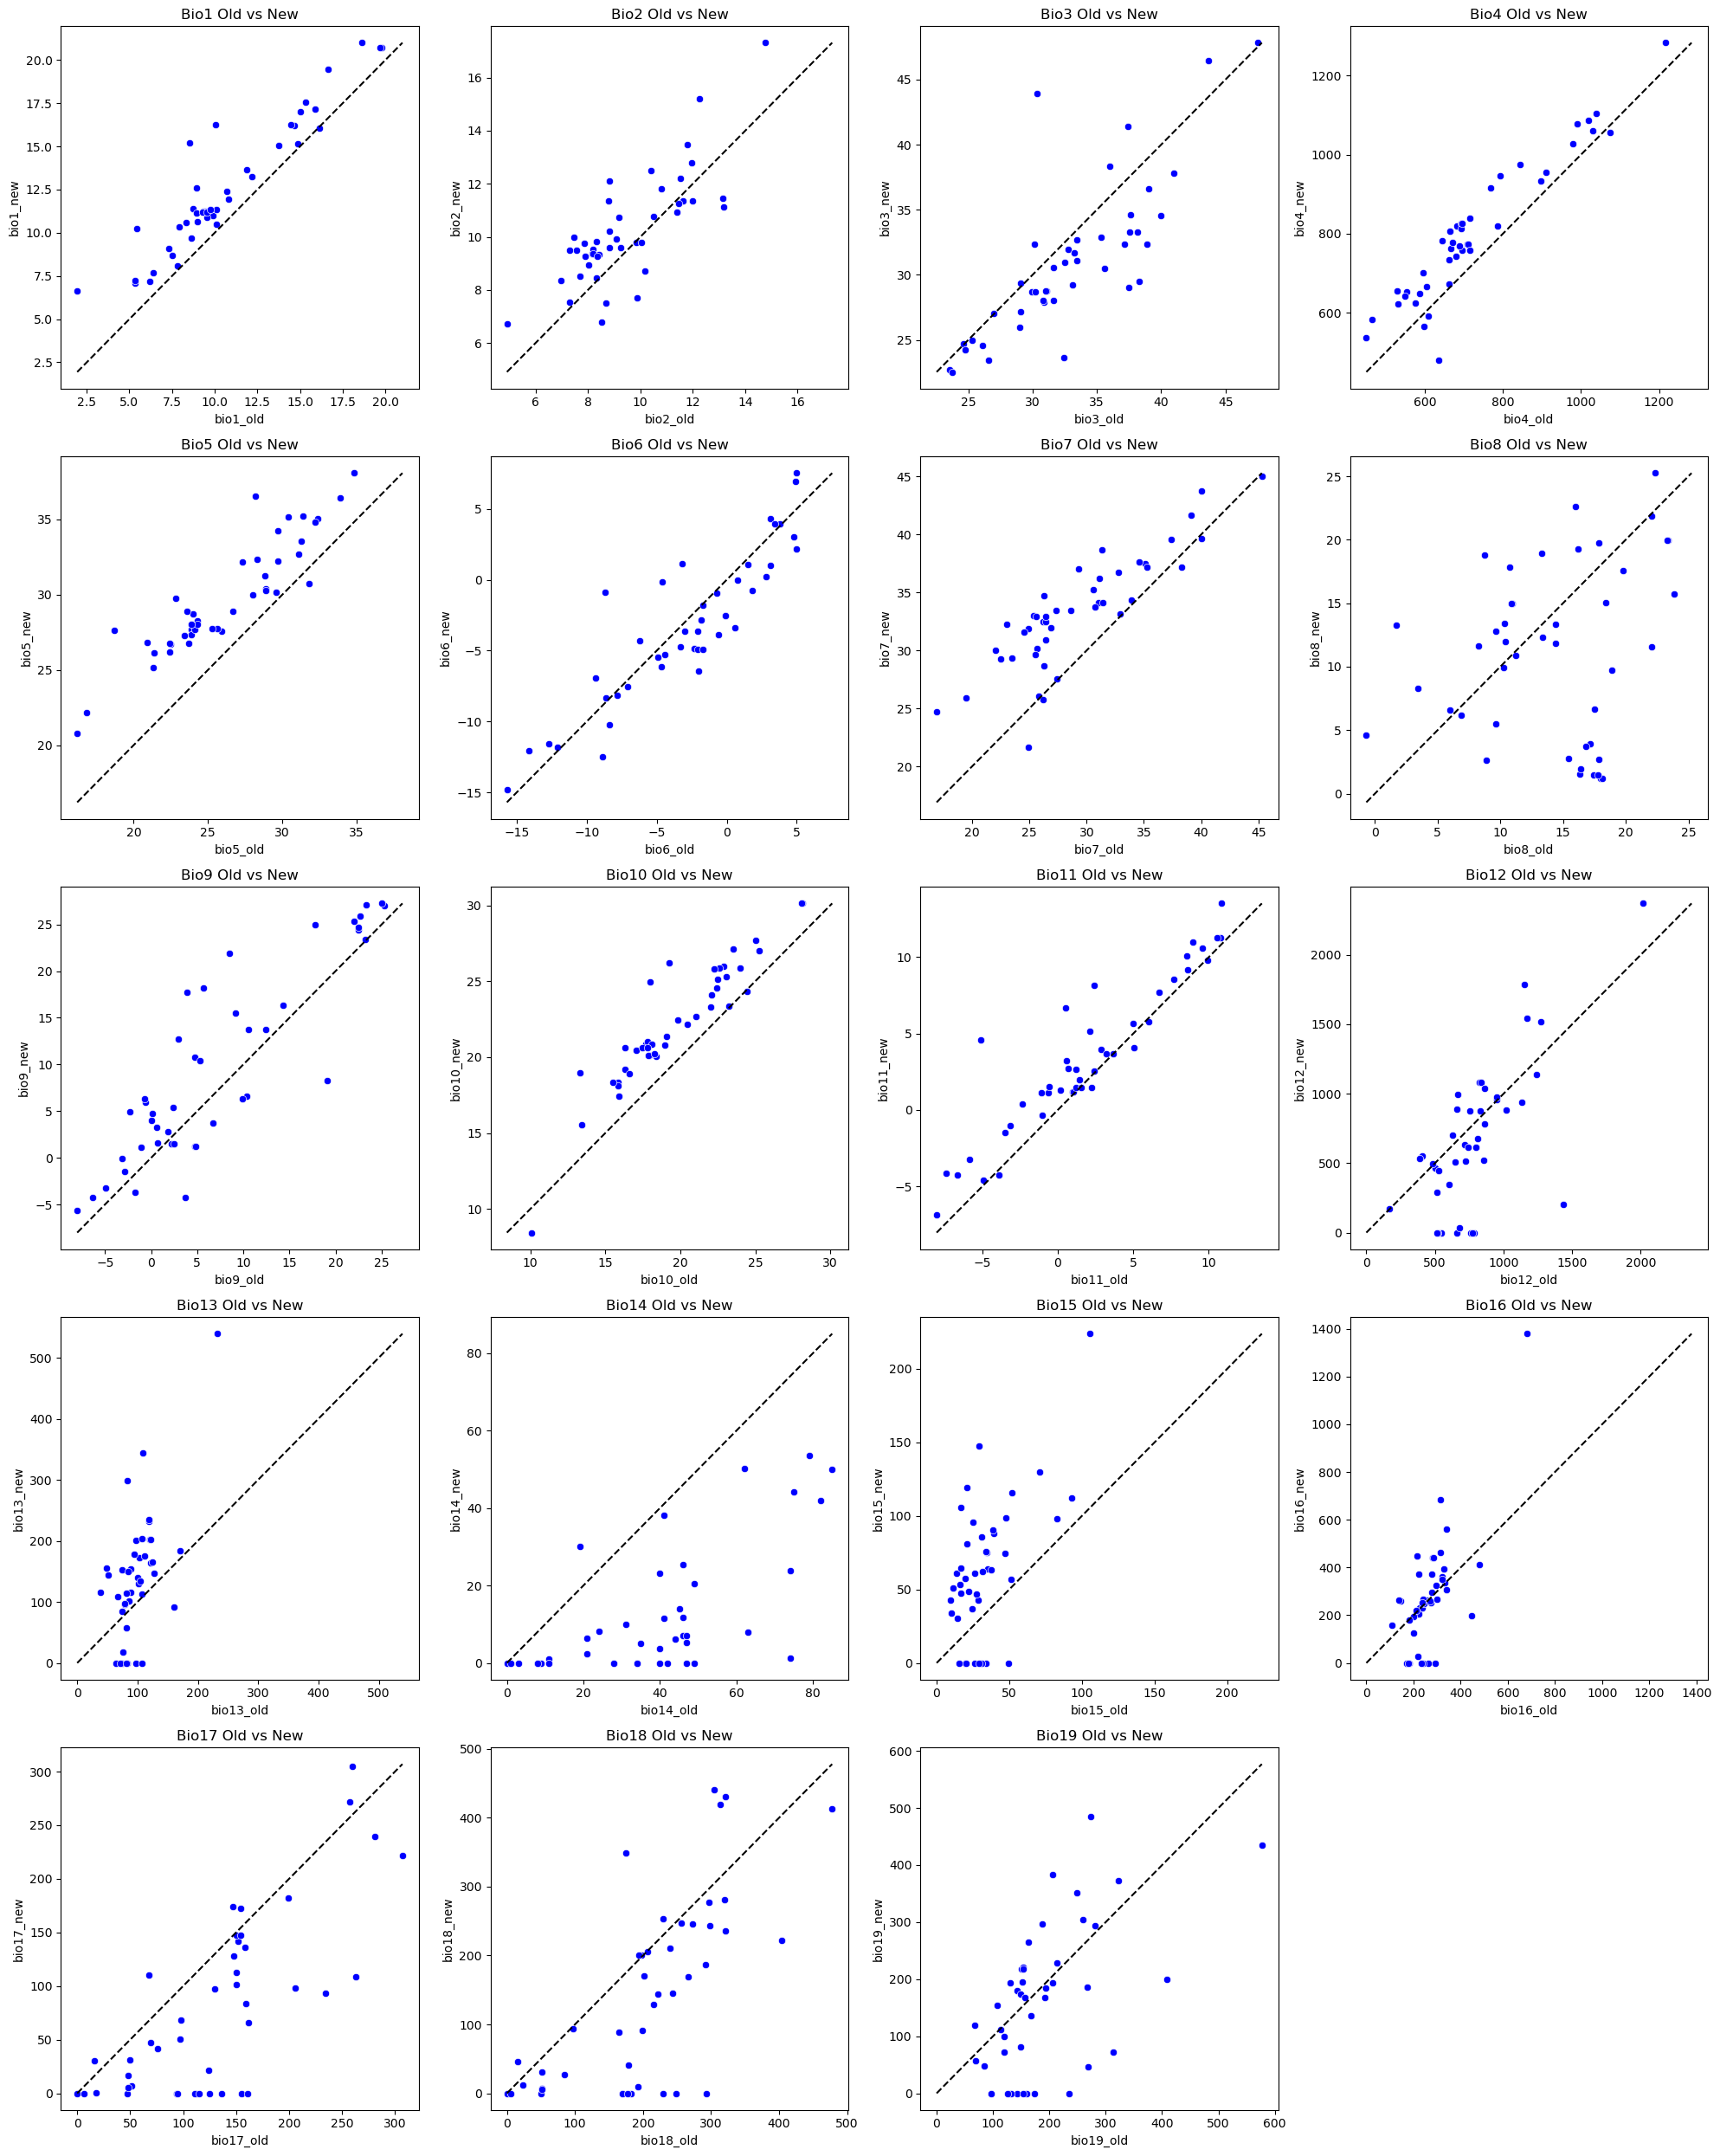

In [334]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'combined_df' has columns like 'bio1_old', 'bio1_new', ..., 'bio19_old', 'bio19_new'
# Number of biovars
num_biovars = 19

# Set up the plotting environment, adjusting for 19 subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 25))  # Adjusted to fit 19 plots in a 5x4 grid

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Loop over the number of biovars
for i in range(num_biovars):
    # Construct column names
    old_col = f'bio{i+1}_old'
    new_col = f'bio{i+1}_new'
    
    # Plot each pair
    sns.scatterplot(data=combined_df, x=old_col, y=new_col, ax=axs[i], color='blue')
    axs[i].set_title(f'Bio{i+1} Old vs New')
    
    # Calculate limits for the 1:1 line
    max_limit = np.maximum(combined_df[old_col].max(), combined_df[new_col].max())
    min_limit = np.minimum(combined_df[old_col].min(), combined_df[new_col].min())
    
    # Plot the 1:1 line
    axs[i].plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Black dashed line

# Hide unused subplots if not a perfect grid match
for ax in axs[num_biovars:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [482]:
ws = pd.read_csv('../grene/data/weatherstation_bioclim.csv')

ws = ws[ws['year'] == 2018]
ws = ws.set_index('site')

In [483]:
bio_clim_vars = pd.read_csv('bio_clim_vars.csv')

bio_clim_vars = bio_clim_vars.set_index(climate_test_min_temp.index)

bio_clim_vars.index = bio_clim_vars.index.astype(float).astype(int)

In [484]:
bio_clim_vars = bio_clim_vars.add_suffix('_era5')
ws = ws.add_suffix('_ws')

# Concatenate the dataframes side by side
combined_df = pd.concat([ws, bio_clim_vars], axis=1)

combined_df = combined_df.dropna()

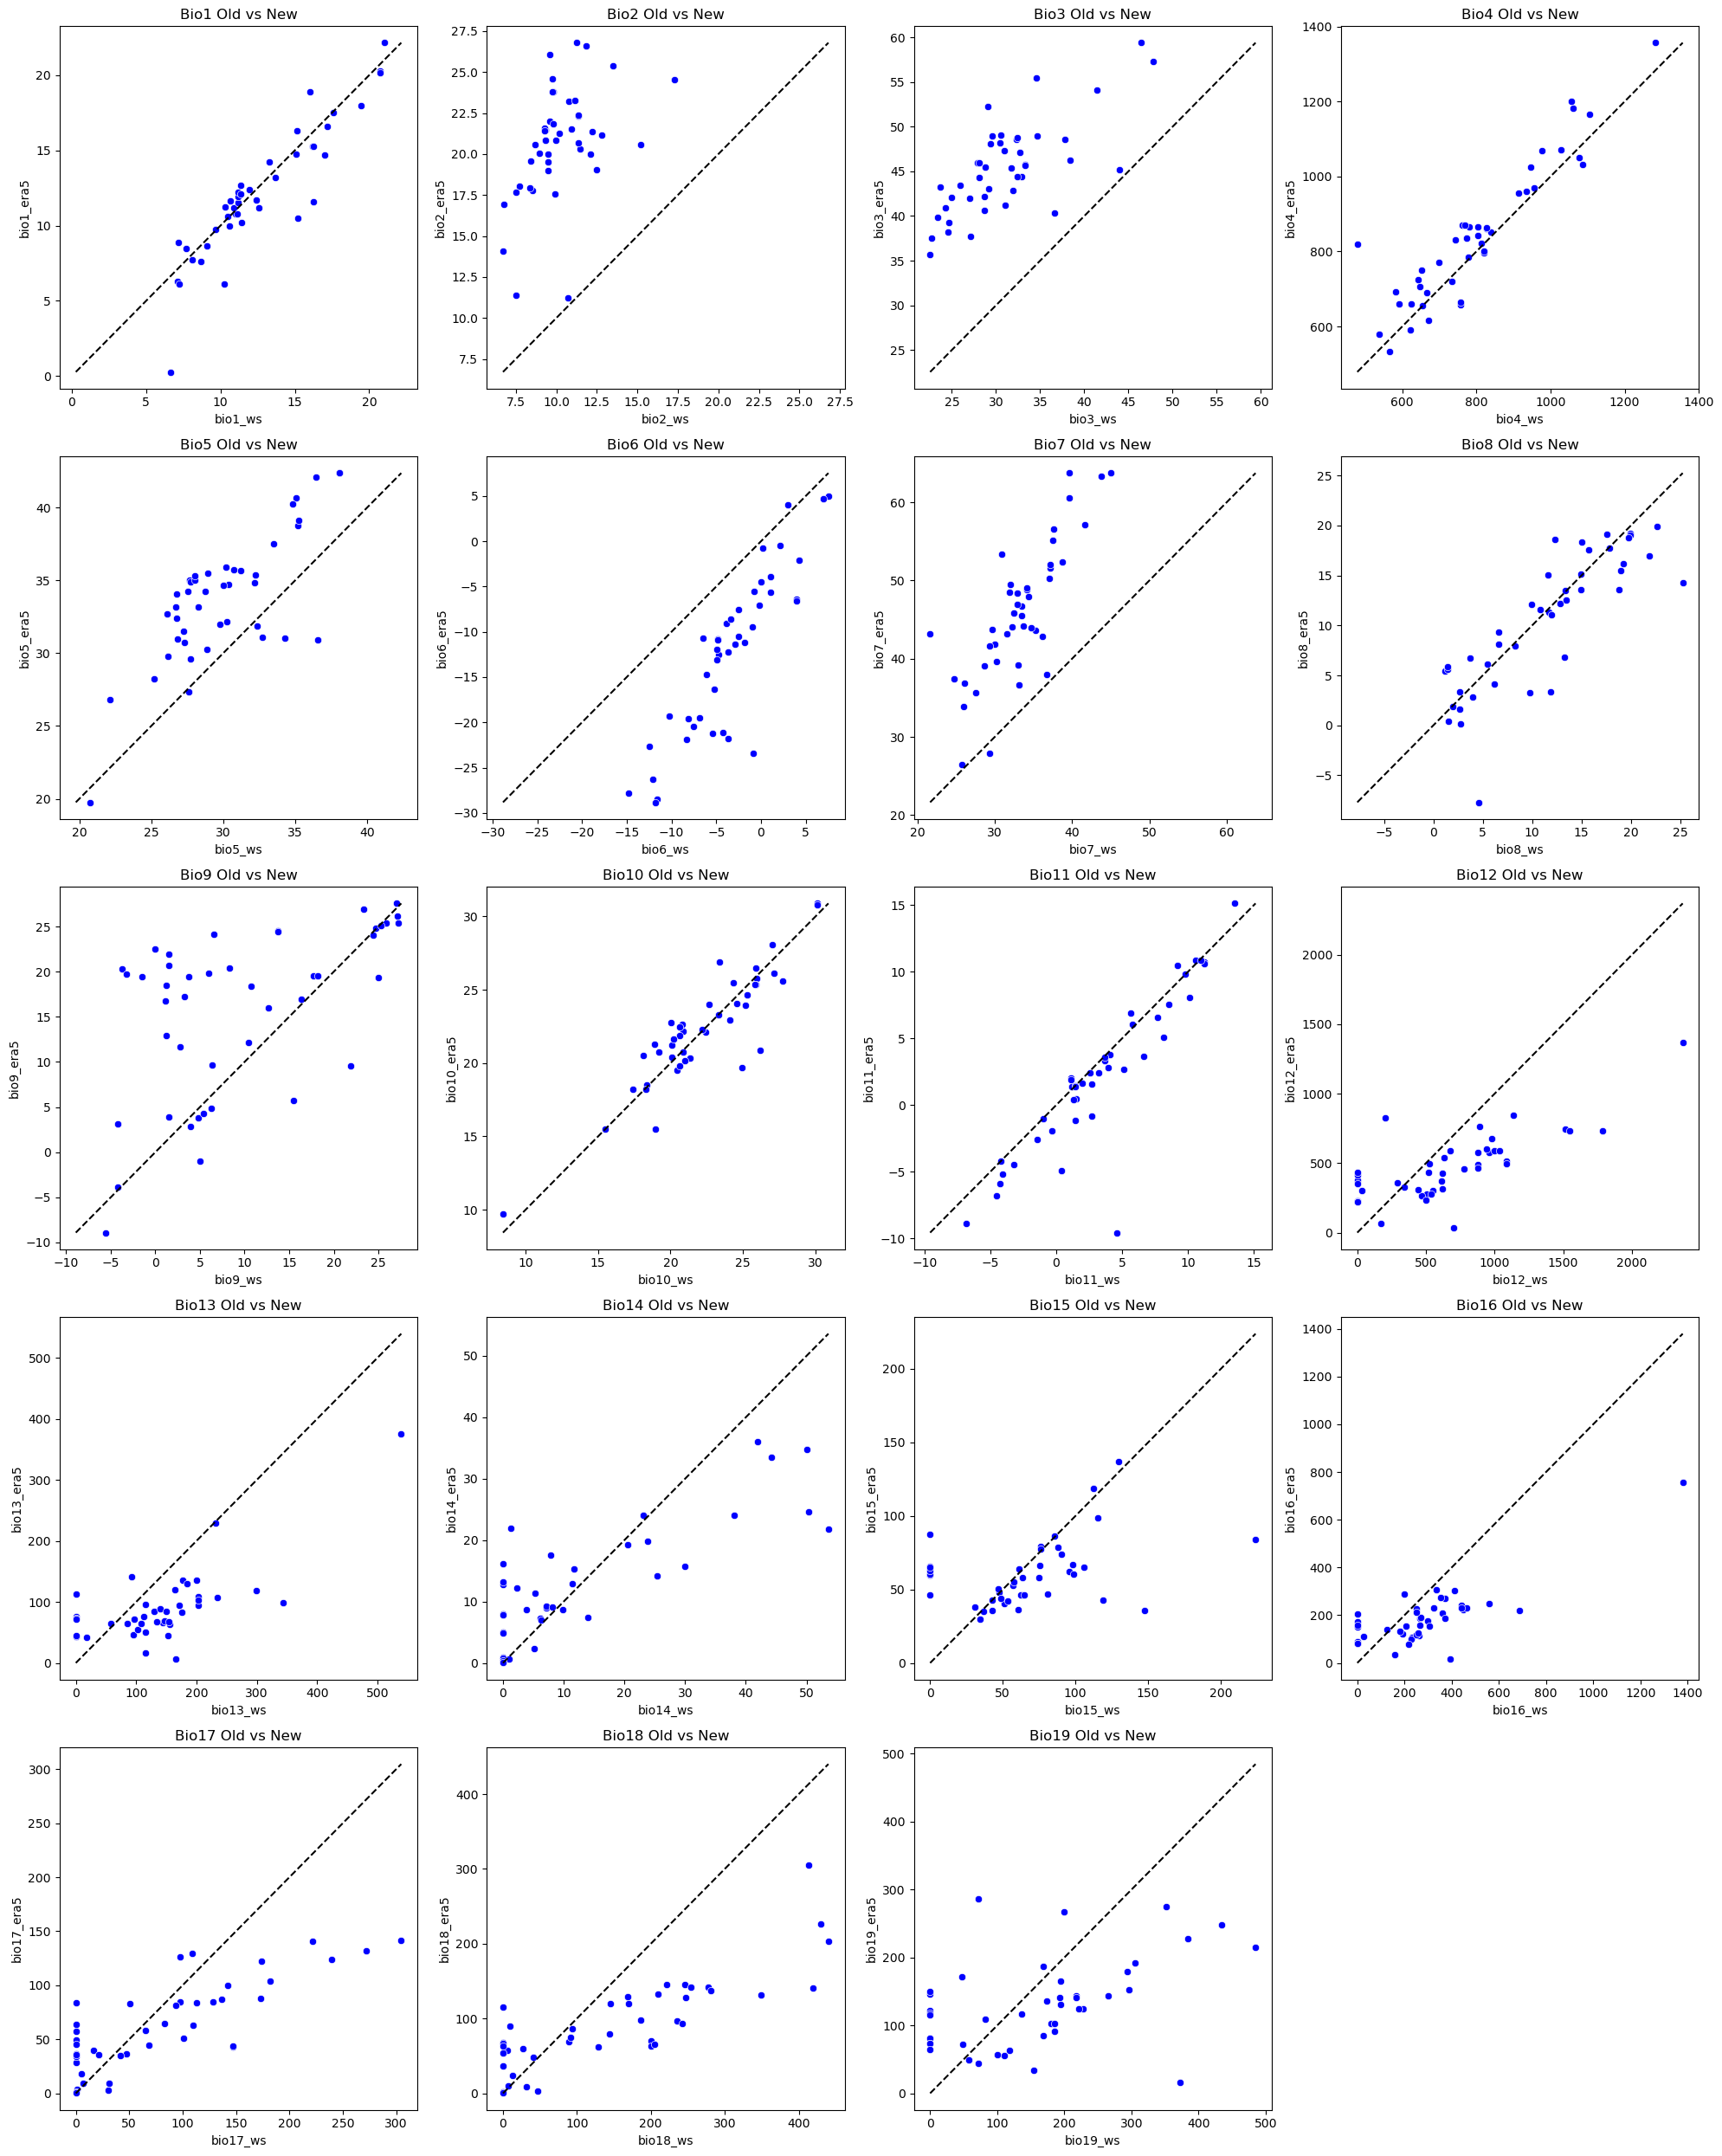

In [485]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'combined_df' has columns like 'bio1_old', 'bio1_new', ..., 'bio19_old', 'bio19_new'
# Number of biovars
num_biovars = 19

# Set up the plotting environment, adjusting for 19 subplots
fig, axs = plt.subplots(5, 4, figsize=(20, 25))  # Adjusted to fit 19 plots in a 5x4 grid

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Loop over the number of biovars
for i in range(num_biovars):
    # Construct column names
    old_col = f'bio{i+1}_ws'
    new_col = f'bio{i+1}_era5'
    
    # Plot each pair
    sns.scatterplot(data=combined_df, x=old_col, y=new_col, ax=axs[i], color='blue')
    axs[i].set_title(f'Bio{i+1} Old vs New')
    
    # Calculate limits for the 1:1 line
    max_limit = np.maximum(combined_df[old_col].max(), combined_df[new_col].max())
    min_limit = np.minimum(combined_df[old_col].min(), combined_df[new_col].min())
    
    # Plot the 1:1 line
    axs[i].plot([min_limit, max_limit], [min_limit, max_limit], 'k--')  # Black dashed line

# Hide unused subplots if not a perfect grid match
for ax in axs[num_biovars:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()